# Banking and Poverty
---
The below script explores the relationship between states with high poverty rates and bank counts per state.

In this script, we retrieved and plotted data from the 2013 US Census and Google Places API to show the relationship between various socioeconomic parameters and bank count across 700 randomly selected zip codes. We used Pandas, Numpy, Matplotlib, Requests, Census API, and Google API to accomplish our task.

In [1]:
# Dependencies
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt


# Census API Key
c = Census(census_key, year=2013)

## Data Retrieval

In [2]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("B01003_001E", "B17001_002E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Poverty Rate"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population,Poverty Rate
0,01832,22121.0,10.903666
1,01833,8295.0,2.302592
2,01834,6675.0,2.187266
3,01835,13527.0,8.523693
4,01840,4547.0,39.542556


## Combine Data

In [3]:
# Import the zip bank data. Use dtype="object" to ensure all data is read in accurately.
census_data_original = pd.read_csv(
    "../Resources/zip_bank_data.csv", dtype="object", encoding="utf-8")

# Visualize
census_data_original.head()

,Zipcode,Address,Median Age,Household Income,Per Capita Income,Lat,Lng,Bank Count
0,624,"Hastings, MI 49058, USA",40.8,46777,22137,42.6306916,-85.2929384,9
1,692,"Ball, LA 71405, USA",35.8,55242,23941,31.4061799,-92.396174,12
2,730,"Great Mills, MD 20634, USA",31.9,79944,35961,38.2201614,-76.4967919,9
3,757,"Williamsport, TN 38487, USA",41.6,38125,18884,35.7310368,-87.2419299,0
4,957,"Marion, ND 58466, USA",44.5,69844,36981,46.5594224,-98.3481542,1


In [4]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(
    census_data_original, census_pd, how="left", on=["Zipcode", "Zipcode"])

# Remove rows missing data
census_data_complete = census_data_complete.dropna()

# Visualize
census_data_complete.head()

,Zipcode,Address,Median Age,Household Income,Per Capita Income,Lat,Lng,Bank Count,Population,Poverty Rate
63,10007,"Flatonia, TX 78941, USA",45.7,40304,23115,29.7574106,-97.1574784,0,6525.0,2.206897
64,10303,"Nevada, IA 50201, USA",40.4,56619,28908,42.065743,-93.4599326,7,24537.0,21.828259
65,10309,"Lukachukai, AZ 86507, USA",24.1,22009,8346,36.4106866,-109.2593642,0,32646.0,6.766526
66,10553,"Lone Pine, CA 93545, USA",40.6,32473,18444,36.5131184,-118.0888578,0,9895.0,15.260232
67,10803,"Niagara, WI 54151, USA",45.7,45813,23500,45.715354,-87.9804239,2,12439.0,3.006673


## Heatmap of Poverty Rate

In [5]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [6]:
# Store 'Lat' and 'Lng' into  locations 
locations = census_data_complete[["Lat", "Lng"]].astype(float)

# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
census_data_complete = census_data_complete.dropna()
poverty_rate = census_data_complete["Poverty Rate"].astype(float)

In [7]:
# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [8]:
# Convert bank rate to list
bank_rate = census_data_complete["Bank Count"].tolist()

In [9]:
# Create bank symbol layer
bank_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"Bank amount: {bank}" for bank in bank_rate]
)


fig = gmaps.figure()
fig.add_layer(bank_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [10]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(bank_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Statistical Analysis

#### Summary Statistics

In [11]:
# Mean, median, mode for Poverty Rate
poverty_mean = round(census_data_complete['Poverty Rate'].astype('float').mean(), 2)
poverty_median = round(census_data_complete['Poverty Rate'].astype('float').median(), 2)
poverty_mode = round(census_data_complete['Poverty Rate'].astype('float').mode(), 2)

print(f"Poverty Rate Mean: {poverty_mean}")
print(f"Poverty Rate Median {poverty_median}")
print(f"Poverty Rate mode {poverty_mode}")

Poverty Rate Mean: 14.62
Poverty Rate Median 12.49
Poverty Rate mode 0    0.0
dtype: float64


In [12]:
# Mean, median, mode for Bank Count
bank_mean = round(census_data_complete['Bank Count'].astype('float').mean(), 2)
bank_median = round(census_data_complete['Bank Count'].astype('float').median(), 2)
bank_mode = round(census_data_complete['Bank Count'].astype('float').mode(), 2)

print(f"Bank Count Mean: {bank_mean}")
print(f"Bank Count Median {bank_median}")
print(f"Bank Count mode {bank_mode}")

Bank Count Mean: 21.11
Bank Count Median 2.0
Bank Count mode 0    0.0
dtype: float64


In [13]:
# Mean, median, mode for Population
population_mean = round(census_data_complete['Population'].astype('float').mean(), 2)
population_median = round(census_data_complete['Population'].astype('float').median(), 2)
population_mode = round(census_data_complete['Population'].astype('float').mode(), 2)

print(f"Population Mean: {population_mean}")
print(f"Population Median {population_median}")
print(f"Population mode {population_mode}")

Population Mean: 10115.99
Population Median 2971.0
Population mode 0    337.0
dtype: float64


#### Linear Regression

R squared: 0.00546199019214101


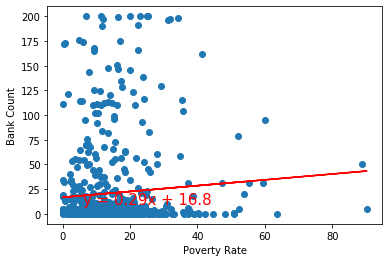

In [14]:
## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = census_data_complete['Poverty Rate'].astype('float')
y_values = census_data_complete['Bank Count'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Poverty Rate')
plt.ylabel('Bank Count')

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()

### Analysis
* There is a very weak correlation between poverty rates and bank counts. Keep in mind that linear regression will not consider other factors such as population or size of the city.